In [1]:
# ============================================================================
# IMPORT CÁC THƯ VIỆN CẦN THIẾT CHO XAI-RL FRAMEWORK
# ============================================================================

# 1. System & Path
import sys
import os
sys.path.append('d:\\NCKH\\SARSA_FinancialRL')

# 2. Data Processing
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 3. Deep Learning - PyTorch
import torch
from torch import nn
import torch.nn.functional as F

# 4. Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style cho plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 5. XAI Libraries - CHỈ DÙNG SHAP
try:
    import shap
    print("✓ SHAP available")
except ImportError:
    print("⚠ SHAP not installed - will install when needed")

# 6. Project-specific Imports
from agents.d_sarsa.d_sarsa import Qsa
from environments.stock_trading_env.mdp import StockTradingMDP
from data.data_provider.library_extracted.vnstock.VNStockDataProvider import VNStockDataProvider
from data.data_processor.feature_engineer import engineer_stat as es

# 7. Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("="*80)
print("✓ Tất cả thư viện đã được import thành công!")
print("="*80)
print("\n🎯 XAI-RL Framework - 3 Phương pháp độc lập:")
print("  [1] RDX  - Reward Decomposition (weights từ domain knowledge)")
print("  [2] MSX  - Multi-Step Explanation (trajectory analysis)")
print("  [3] SHAP - Feature Attribution (Shapley values)")
print("\n📊 Deep RL Agent:")
print("  • Qsa:              Q-network (input=7, output=11)")
print("  • StockTradingMDP:  Environment cho stock trading")
print("  • VNStockData:      Data provider cho VN market")
print("\nReady to analyze SARSA agent! 🚀")
print("="*80)

✓ SHAP available


✓ Tất cả thư viện đã được import thành công!

🎯 XAI-RL Framework - 3 Phương pháp độc lập:
  [1] RDX  - Reward Decomposition (weights từ domain knowledge)
  [2] MSX  - Multi-Step Explanation (trajectory analysis)
  [3] SHAP - Feature Attribution (Shapley values)

📊 Deep RL Agent:
  • Qsa:              Q-network (input=7, output=11)
  • StockTradingMDP:  Environment cho stock trading
  • VNStockData:      Data provider cho VN market

Ready to analyze SARSA agent! 🚀


In [2]:
# # 1.2. Load dữ liệu ACB
# provider = VNStockDataProvider()
# print("\nĐang lấy dữ liệu ACB từ vnstock...")
# df_raw = provider.get_ohlcv_data('ACB', '2012-12-14', '2022-12-31')
# print(f"✓ Đã lấy {len(df_raw)} dòng dữ liệu")

# # 1.3. Xử lý dữ liệu và thêm technical indicators
# df_processed = df_raw.copy()
# df_processed.rename(columns={'date': 'time'}, inplace=True)
# df_processed['time'] = pd.to_datetime(df_processed['time']).dt.strftime('%d/%m/%Y')
# df_processed = es.add_technical_indicators(df_processed, start_date= '01/01/2013')
# print(f"✓ Đã thêm technical indicators: {df_processed.shape}")

# # 1.4. Khởi tạo MDP và chạy simulation
# mdp = StockTradingMDP(balance_init=1000, k=5, min_balance=-100)

# def pi_deep(s, eps=0.0, greedy=True):
#     with torch.no_grad():
#         out_qsa = qsa(torch.Tensor(s).float()).squeeze()
#         action = out_qsa.argmax().item() - 5
#     return action

# # State ban đầu
# first_row = df_processed.iloc[0]
# state_init = [
#     float(first_row['close']),
#     mdp.balance_init,
#     0,
#     float(first_row['MACD']),
#     float(first_row['RSI']),
#     float(first_row['CCI']),
#     float(first_row['ADX'])
# ]

# # Chạy simulation
# print("\nĐang chạy simulation...")
# states, rewards, actions = mdp.simulate(
#     df_processed[1:].reset_index(drop=True), 
#     state_init, 
#     pi_deep, 
#     greedy=True, 
#     eps=0.0
# )

# print(f"✓ Simulation hoàn tất: {len(states)} states, {len(actions)} actions")
# print(f"  Total reward: {sum(rewards):.2f}")
# print(f"  Final portfolio: ${states[-1][1] + states[-1][0]*states[-1][2]:.2f}")

In [3]:
# 1.1. Load model SARSA
qsa = Qsa(input_size=7, num_classes=11)
model_path_1 = 'd:\\NCKH\\SARSA_FinancialRL\\models\\sarsa_bad_acb.pth'

if os.path.exists(model_path_1):
    state_dict = torch.load(model_path_1, map_location=torch.device('cpu'))
    qsa.load_state_dict(state_dict)
    qsa.eval()
    print(f"✓ Model loaded: {model_path_1}")
else:
    print(f"✗ Model not found: {model_path_1}")

✓ Model loaded: d:\NCKH\SARSA_FinancialRL\models\sarsa_bad_acb.pth


In [4]:
df_processed_1 = pd.read_csv('D:\\NCKH\\SARSA_FinancialRL\\data\\data_storer\\data_research\\test\\good_test_ACB.csv')


In [5]:
# 1.4. Khởi tạo MDP và chạy simulation
mdp = StockTradingMDP(balance_init=1000, k=5, min_balance=-100)

def pi_deep(s, eps=0.0, greedy=True):
    with torch.no_grad():
        out_qsa = qsa(torch.Tensor(s).float()).squeeze()
        action = out_qsa.argmax().item() - 5
    return action

# State ban đầu
first_row = df_processed_1.iloc[0]
state_init = [
    float(first_row['close']),
    mdp.balance_init,
    0,
    float(first_row['MACD']),
    float(first_row['RSI']),
    float(first_row['CCI']),
    float(first_row['ADX'])
]

# Chạy simulation
print("\nĐang chạy simulation...")
states, rewards, actions = mdp.simulate(
    df_processed_1[1:].reset_index(drop=True), 
    state_init, 
    pi_deep, 
    greedy=True, 
    eps=0.0
)

print(f"✓ Simulation hoàn tất: {len(states)} states, {len(actions)} actions")
print(f"  Total reward: {sum(rewards):.2f}")
print(f"  Final portfolio: ${states[-1][1] + states[-1][0]*states[-1][2]:.2f}")


Đang chạy simulation...
✓ Simulation hoàn tất: 747 states, 746 actions
  Total reward: 1085.07
  Final portfolio: $2085.07


## SHAP cho states agent vừa mô phỏng
Mục tiêu: giải thích đóng góp của từng feature (giá, vốn, vị thế, MACD, RSI, CCI, ADX) lên Q-value của hành động mà agent đã chọn tại mỗi timestep. Chúng ta sử dụng KernelExplainer cho dữ liệu tabular và hàm dự đoán trả về Q-value của hành động đã thực thi.

In [6]:
# Chuẩn bị dữ liệu X và hàm dự đoán cho SHAP
import importlib
if importlib.util.find_spec('shap') is None:
    import sys, subprocess
    print('Đang cài đặt shap...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'shap'])
    import shap
else:
    import shap

# Ma trận trạng thái từ mô phỏng
X = np.array(states, dtype=np.float32)
feature_names = ['close','balance','position','MACD','RSI','CCI','ADX']

# Hàm dự đoán: trả về Q-value của hành động greedy (argmax) cho mỗi hàng
def predict_q_greedy(X_batch):
    X_t = torch.tensor(X_batch, dtype=torch.float32)
    with torch.no_grad():
        q = qsa(X_t)  # [N, 11]
        # Lấy Q-value theo hành động có Q lớn nhất cho từng hàng
        ai = torch.argmax(q, dim=1)  # [N]
        out = q.gather(dim=1, index=ai.view(-1,1)).squeeze(1)  # [N]
        return out.cpu().numpy().astype(np.float32)

print(f'X shape: {X.shape}')

X shape: (747, 7)


In [7]:
# Tính SHAP values với KernelExplainer (có thể mất vài phút với dữ liệu lớn)
# Chọn background nhỏ để tăng tốc
rng = np.random.default_rng(42)
bg_idx = rng.choice(len(X), size=min(2000, len(X)), replace=False)
X_bg = X[bg_idx]

# Chọn sample để giải thích (ví dụ 300 bước gần nhất hoặc toàn bộ nếu ít hơn)
sample_len = len(X)
X_sample = X[-sample_len:]

explainer = shap.KernelExplainer(predict_q_greedy, X_bg)
shap_values = explainer.shap_values(X_sample, nsamples='auto')
print('✓ Đã tính xong SHAP values cho sample:', len(X_sample))

Using 747 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/747 [00:00<?, ?it/s]

✓ Đã tính xong SHAP values cho sample: 747


In [8]:
X

array([[   6.48     , 1000.       ,    0.       , ...,   44.187397 ,
         -56.914562 ,   30.30283  ],
       [   6.24     ,  987.02704  ,    2.       , ...,   34.867844 ,
        -160.03062  ,   31.508307 ],
       [   6.28     ,  974.53455  ,    4.       , ...,   37.243526 ,
        -122.21587  ,   32.627678 ],
       ...,
       [  15.85     ,  386.31693  ,  105.       , ...,   57.766064 ,
         181.60378  ,   13.4290905],
       [  15.9      ,  433.9145   ,  102.       , ...,   58.921032 ,
         146.24797  ,   12.948745 ],
       [  16.18     ,  386.16678  ,  105.       , ...,   64.736755 ,
         213.9265   ,   13.307927 ]], dtype=float32)

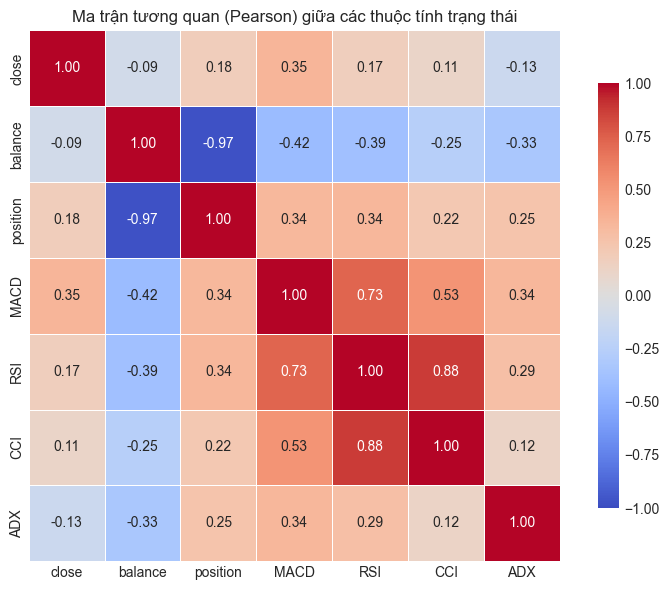

In [9]:
# Tính ma trận tương quan và vẽ heatmap
# Sử dụng dữ liệu states đã mô phỏng
X = np.array(states, dtype=np.float32)
feature_names = ['close','balance','position','MACD','RSI','CCI','ADX']

# Tạo DataFrame để tính tương quan
X_df = pd.DataFrame(X, columns=feature_names)

# Loại bỏ các hàng có NaN (nếu còn)
X_df_clean = X_df.dropna()

# Tính ma trận tương quan Pearson
corr = X_df_clean.corr(method='pearson')

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True,
            fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Ma trận tương quan (Pearson) giữa các thuộc tính trạng thái')
plt.tight_layout()
plt.show()

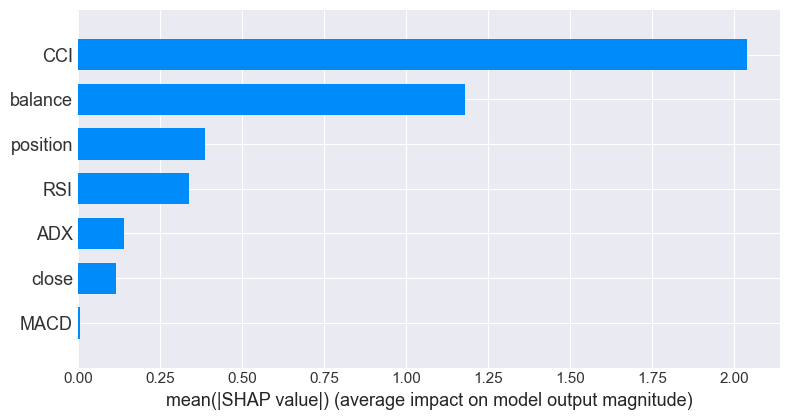

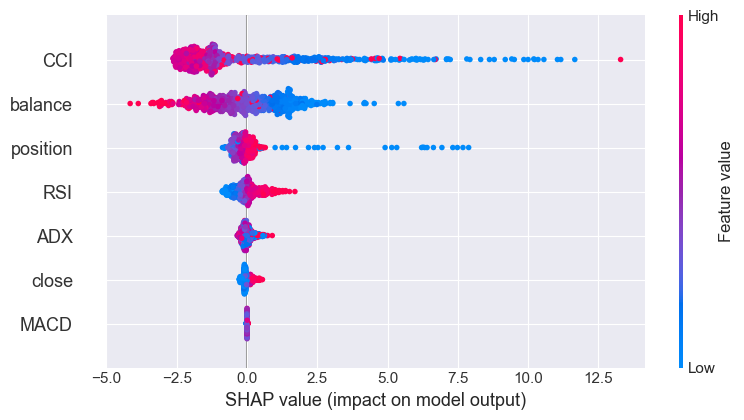

In [10]:
# Visualization: summary bar + beeswarm cho sample
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type='bar', show=False)
# plt.title('SHAP Summary (Bar) - Q của hành động đã thực thi')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
# plt.title('SHAP Beeswarm - Phân phối đóng góp theo timestep')
plt.tight_layout()
plt.show()

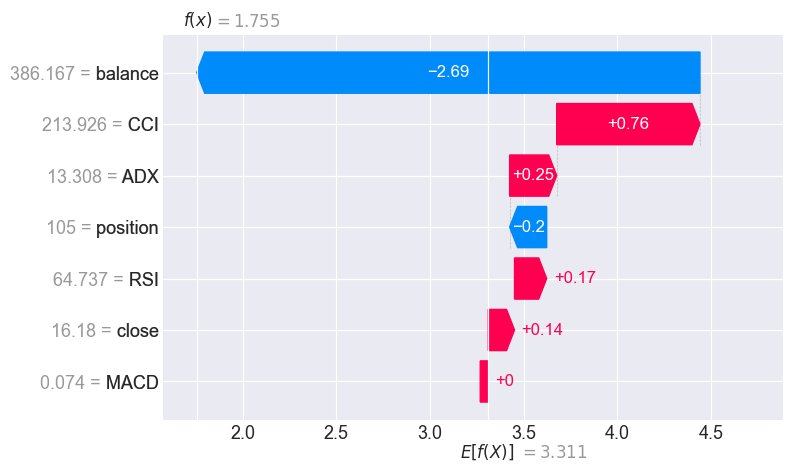

In [11]:
# Waterfall cho một timestep cụ thể (ví dụ timestep cuối cùng)
idx = -1  # phần tử cuối của sample
base_val = np.mean(predict_q_greedy(X_bg))
shap.plots.waterfall(shap.Explanation(values=shap_values[idx],
                                       base_values=base_val,
                                       data=X_sample[idx],
                                       feature_names=feature_names))

In [12]:
from matplotlib.backends.backend_pdf import PdfPages


def save_analysis_to_pdf(X_df_clean, shap_values, X_sample, feature_names, base_val, output_path):
    """
    Lưu các biểu đồ phân tích (Heatmap, SHAP Bar, SHAP Beeswarm, SHAP Waterfall) vào 1 file PDF.
    
    Args:
        X_df_clean: DataFrame đã làm sạch để vẽ Heatmap.
        shap_values: Giá trị SHAP đã tính toán.
        X_sample: Dữ liệu mẫu dùng để tính SHAP.
        feature_names: Danh sách tên các đặc trưng.
        base_val: Giá trị nền (base value) cho Waterfall plot.
        output_path: Đường dẫn lưu file PDF (VD: 'reports/analysis_report.pdf').
    """
    print(f"Đang tạo file PDF tại: {output_path}...")
    
    # Kích thước chuẩn A4 (ngang hoặc dọc tùy chỉnh, ở đây dùng Landscape cho dễ nhìn SHAP)
    # A4 size in inches: 8.27 x 11.69. Landscape: 11.69 x 8.27
    A4_WIDTH = 11.69
    A4_HEIGHT = 8.27

    with PdfPages(output_path) as pdf:
        
        # --- TRANG 1: MA TRẬN TƯƠNG QUAN (HEATMAP) ---
        fig1 = plt.figure(figsize=(10, 8)) # Canh chỉnh cho vừa trang
        corr = X_df_clean.corr(method='pearson')
        sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True,
                    fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
        # plt.title('Ma trận tương quan (Pearson) giữa các thuộc tính trạng thái', fontsize=14)
        plt.tight_layout()
        pdf.savefig(fig1)  # Lưu trang hiện tại
        plt.close(fig1)    # Giải phóng bộ nhớ

        # --- TRANG 2: SHAP SUMMARY (BAR PLOT) ---
        fig2 = plt.figure(figsize=(10, 6))
        # show=False để không hiển thị ngay mà lưu vào figure hiện tại
        shap.summary_plot(shap_values, X_sample, feature_names=feature_names, 
                          plot_type='bar', show=False)
        plt.title('Mức độ quan trọng của đặc trưng (SHAP Bar)', fontsize=14)
        # bbox_inches='tight' cực quan trọng với SHAP để không bị cắt chữ
        plt.tight_layout()
        pdf.savefig(fig2, bbox_inches='tight') 
        plt.close(fig2)

        # --- TRANG 3: SHAP SUMMARY (BEESWARM PLOT) ---
        fig3 = plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
        # plt.title('Phân phối tác động của đặc trưng (SHAP Beeswarm)', fontsize=14)
        plt.tight_layout()
        pdf.savefig(fig3, bbox_inches='tight')
        plt.close(fig3)

        # --- TRANG 4: SHAP WATERFALL (TIMESTEP CUỐI) ---
        # Waterfall của SHAP vẽ hơi khác, cần xử lý khéo
        fig4 = plt.figure(figsize=(10, 6))
        idx = -1
        
        # Waterfall plot vẽ trực tiếp lên current figure
        shap.plots.waterfall(shap.Explanation(values=shap_values[idx],
                                              base_values=base_val,
                                              data=X_sample[idx],
                                              feature_names=feature_names),
                             show=False) # Quan trọng: show=False
        
        # Waterfall thường không có title mặc định, ta có thể add thêm nếu muốn
        # plt.title(f'Giải thích chi tiết cho mẫu cuối cùng (Index {idx})', fontsize=14)
        
        plt.tight_layout()
        pdf.savefig(fig4, bbox_inches='tight')
        plt.close(fig4)
        
    print("✓ Đã lưu thành công file PDF!")

In [13]:
import os

# --- 1. SETUP ĐƯỜNG DẪN CỦA BẠN (GIỮ NGUYÊN) ---
output_dir = "D:\\NCKH\\SARSA_FinancialRL\\application\\results\\xai_analysis\\"

# --- 2. LOGIC TỰ ĐỘNG LẤY TÊN (AUTO-PARSE) ---
# Lấy tên file: "sarsa_bad_acb.pth" -> Bỏ đuôi: "sarsa_bad_acb"
file_name_raw = os.path.splitext(os.path.basename(model_path_1))[0]

# Tách chuỗi bằng dấu gạch dưới "_" -> ['sarsa', 'bad', 'acb']
parts = file_name_raw.split('_')

# Gán biến (Xử lý an toàn nếu tên file thiếu thành phần)
algo_name = parts[0].upper() if len(parts) > 0 else "MODEL"
quality   = parts[1].upper() if len(parts) > 1 else "TYPE"
stock_sym = parts[2].upper() if len(parts) > 2 else "STOCK"

# Tự động tạo tên file PDF đích
# Kết quả sẽ là: SHAP_Report_SARSA_BAD_ACB.pdf
pdf_filename = f"SHAP_Report_{algo_name}_{quality}_{stock_sym}.pdf"
full_output_path = os.path.join(output_dir, pdf_filename)

print(f"🤖 Đã nhận diện từ path: Algo={algo_name}, Type={quality}, Stock={stock_sym}")
print(f"📄 File PDF sẽ được lưu là: {pdf_filename}")

# --- 3. GỌI HÀM LƯU (DÙNG BIẾN full_output_path VỪA TẠO) ---
# Đảm bảo thư mục tồn tại
os.makedirs(output_dir, exist_ok=True)

try:
    save_analysis_to_pdf(X_df_clean, shap_values, X_sample, feature_names, base_val, full_output_path)
    print(f"✓ Đã lưu xong tại: {full_output_path}")
except PermissionError:
    print("❌ LỖI: File đang mở, vui lòng đóng file PDF lại!")

🤖 Đã nhận diện từ path: Algo=SARSA, Type=BAD, Stock=ACB
📄 File PDF sẽ được lưu là: SHAP_Report_SARSA_BAD_ACB.pdf
Đang tạo file PDF tại: D:\NCKH\SARSA_FinancialRL\application\results\xai_analysis\SHAP_Report_SARSA_BAD_ACB.pdf...
✓ Đã lưu thành công file PDF!
✓ Đã lưu xong tại: D:\NCKH\SARSA_FinancialRL\application\results\xai_analysis\SHAP_Report_SARSA_BAD_ACB.pdf


# Thử nghiệm cho model_path_2

In [14]:
# 1.1. Load model SARSA
qsa = Qsa(input_size=7, num_classes=11)
model_path_2 = 'd:\\NCKH\\SARSA_FinancialRL\\models\\sarsa_good_acb.pth'

if os.path.exists(model_path_2):
    state_dict = torch.load(model_path_2, map_location=torch.device('cpu'))
    qsa.load_state_dict(state_dict)
    qsa.eval()
    print(f"✓ Model loaded: {model_path_2}")
else:
    print(f"✗ Model not found: {model_path_2}")

✓ Model loaded: d:\NCKH\SARSA_FinancialRL\models\sarsa_good_acb.pth


In [15]:
df_processed_2 = pd.read_csv('D:\\NCKH\\SARSA_FinancialRL\\data\\data_storer\\data_research\\test\\bad_test_ACB.csv')

In [16]:
# 1.4. Khởi tạo MDP và chạy simulation
mdp_2 = StockTradingMDP(balance_init=1000, k=5, min_balance=-100)

def pi_deep_2(s, eps=0.0, greedy=True):
    with torch.no_grad():
        out_qsa = qsa(torch.Tensor(s).float()).squeeze()
        action = out_qsa.argmax().item() - 5
    return action

# State ban đầu
first_row_2 = df_processed_2.iloc[0]
state_init = [
    float(first_row_2['close']),
    mdp_2.balance_init,
    0,
    float(first_row_2['MACD']),
    float(first_row_2['RSI']),
    float(first_row_2['CCI']),
    float(first_row_2['ADX'])
]

# Chạy simulation
print("\nĐang chạy simulation...")
states_2, rewards_2, actions_2 = mdp_2.simulate(
    df_processed_2[1:].reset_index(drop=True), 
    state_init, 
    pi_deep_2, 
    greedy=True, 
    eps=0.0
)

print(f"✓ Simulation hoàn tất: {len(states_2)} states, {len(actions_2)} actions")
print(f"  Total reward: {sum(rewards_2):.2f}")
print(f"  Final portfolio: ${states_2[-1][1] + states_2[-1][0]*states_2[-1][2]:.2f}")


Đang chạy simulation...
✓ Simulation hoàn tất: 498 states, 497 actions
  Total reward: 68.59
  Final portfolio: $1068.59


In [17]:
# Chuẩn bị dữ liệu X và hàm dự đoán cho SHAP
import importlib
if importlib.util.find_spec('shap') is None:
    import sys, subprocess
    print('Đang cài đặt shap...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'shap'])
    import shap
else:
    import shap

# Ma trận trạng thái từ mô phỏng
X = np.array(states_2, dtype=np.float32)
feature_names = ['close','balance','position','MACD','RSI','CCI','ADX']

# Hàm dự đoán: trả về Q-value của hành động greedy (argmax) cho mỗi hàng
def predict_q_greedy(X_batch):
    X_t = torch.tensor(X_batch, dtype=torch.float32)
    with torch.no_grad():
        q = qsa(X_t)  # [N, 11]
        # Lấy Q-value theo hành động có Q lớn nhất cho từng hàng
        ai = torch.argmax(q, dim=1)  # [N]
        out = q.gather(dim=1, index=ai.view(-1,1)).squeeze(1)  # [N]
        return out.cpu().numpy().astype(np.float32)

print(f'X shape: {X.shape}')

X shape: (498, 7)


In [18]:
# Tính SHAP values với KernelExplainer (có thể mất vài phút với dữ liệu lớn)
# Chọn background nhỏ để tăng tốc
rng = np.random.default_rng(42)
bg_idx = rng.choice(len(X), size=min(2000, len(X)), replace=False)
X_bg = X[bg_idx]

# Chọn sample để giải thích (ví dụ 300 bước gần nhất hoặc toàn bộ nếu ít hơn)
sample_len = len(X)
X_sample = X[-sample_len:]

explainer = shap.KernelExplainer(predict_q_greedy, X_bg)
shap_values = explainer.shap_values(X_sample, nsamples='auto')
print('✓ Đã tính xong SHAP values cho sample:', len(X_sample))

Using 498 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/498 [00:00<?, ?it/s]

✓ Đã tính xong SHAP values cho sample: 498


In [19]:
X

array([[  16.13    , 1000.      ,    0.      , ...,   63.020958,
         201.75124 ,   13.985882],
       [  15.8     ,  951.5616  ,    3.      , ...,   53.03081 ,
          91.60757 ,   13.486437],
       [  15.83    ,  904.1142  ,    6.      , ...,   53.74861 ,
          40.34158 ,   12.895065],
       ...,
       [  16.35    ,   13.84483 ,   63.      , ...,   65.388016,
         105.07395 ,   21.269247],
       [  16.67    ,   95.67658 ,   58.      , ...,   72.16019 ,
         144.8599  ,   23.46238 ],
       [  16.77    ,   45.61657 ,   61.      , ...,   73.880104,
         159.46405 ,   25.73371 ]], dtype=float32)

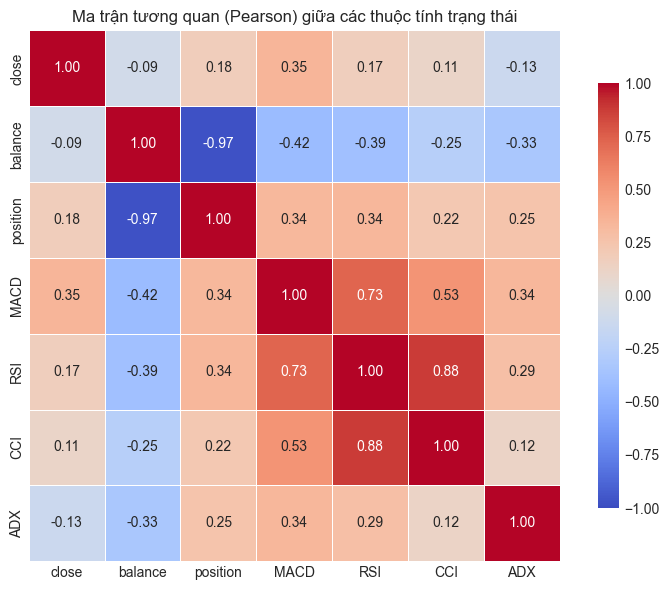

In [20]:
# Tính ma trận tương quan và vẽ heatmap
# Sử dụng dữ liệu states đã mô phỏng
X = np.array(states, dtype=np.float32)
feature_names = ['close','balance','position','MACD','RSI','CCI','ADX']

# Tạo DataFrame để tính tương quan
X_df = pd.DataFrame(X, columns=feature_names)

# Loại bỏ các hàng có NaN (nếu còn)
X_df_clean = X_df.dropna()

# Tính ma trận tương quan Pearson
corr = X_df_clean.corr(method='pearson')

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True,
            fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Ma trận tương quan (Pearson) giữa các thuộc tính trạng thái')
plt.tight_layout()
plt.show()

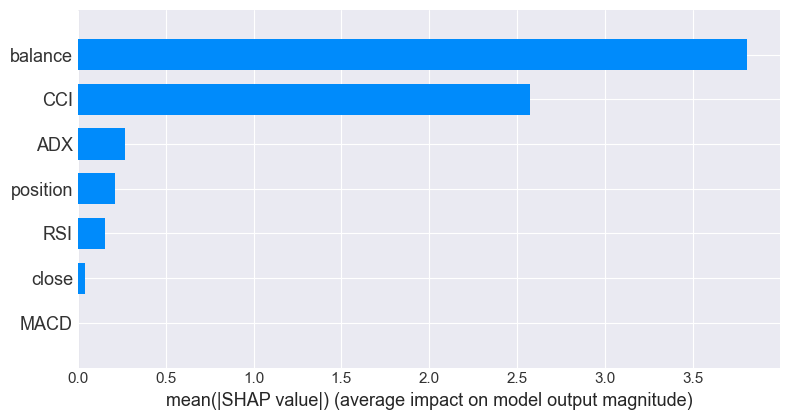

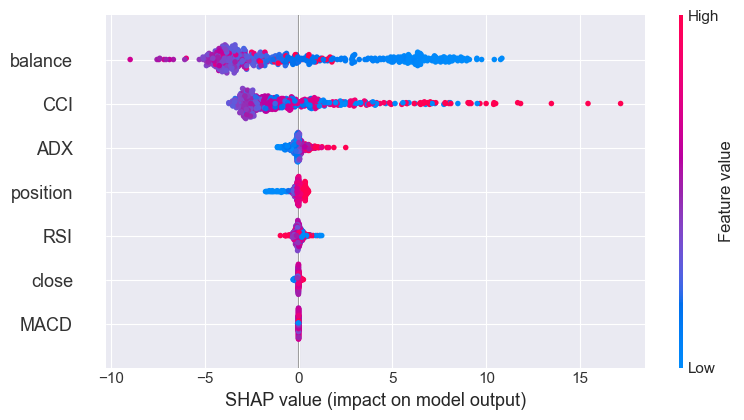

In [21]:
# Visualization: summary bar + beeswarm cho sample
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type='bar', show=False)
# plt.title('SHAP Summary (Bar) - Q của hành động đã thực thi')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
# plt.title('SHAP Beeswarm - Phân phối đóng góp theo timestep')
plt.tight_layout()
plt.show()

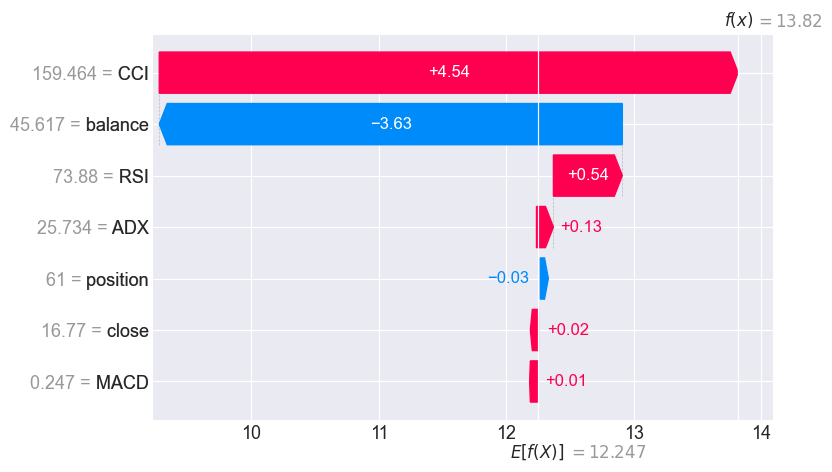

In [22]:
# Waterfall cho một timestep cụ thể (ví dụ timestep cuối cùng)
idx = -1  # phần tử cuối của sample
base_val = np.mean(predict_q_greedy(X_bg))
shap.plots.waterfall(shap.Explanation(values=shap_values[idx],
                                       base_values=base_val,
                                       data=X_sample[idx],
                                       feature_names=feature_names))

In [23]:
from matplotlib.backends.backend_pdf import PdfPages


def save_analysis_to_pdf(X_df_clean, shap_values, X_sample, feature_names, base_val, output_path):
    """
    Lưu các biểu đồ phân tích (Heatmap, SHAP Bar, SHAP Beeswarm, SHAP Waterfall) vào 1 file PDF.
    
    Args:
        X_df_clean: DataFrame đã làm sạch để vẽ Heatmap.
        shap_values: Giá trị SHAP đã tính toán.
        X_sample: Dữ liệu mẫu dùng để tính SHAP.
        feature_names: Danh sách tên các đặc trưng.
        base_val: Giá trị nền (base value) cho Waterfall plot.
        output_path: Đường dẫn lưu file PDF (VD: 'reports/analysis_report.pdf').
    """
    print(f"Đang tạo file PDF tại: {output_path}...")
    
    # Kích thước chuẩn A4 (ngang hoặc dọc tùy chỉnh, ở đây dùng Landscape cho dễ nhìn SHAP)
    # A4 size in inches: 8.27 x 11.69. Landscape: 11.69 x 8.27
    A4_WIDTH = 11.69
    A4_HEIGHT = 8.27

    with PdfPages(output_path) as pdf:
        
        # --- TRANG 1: MA TRẬN TƯƠNG QUAN (HEATMAP) ---
        fig1 = plt.figure(figsize=(10, 8)) # Canh chỉnh cho vừa trang
        corr = X_df_clean.corr(method='pearson')
        sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True,
                    fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
        # plt.title('Ma trận tương quan (Pearson) giữa các thuộc tính trạng thái', fontsize=14)
        plt.tight_layout()
        pdf.savefig(fig1)  # Lưu trang hiện tại
        plt.close(fig1)    # Giải phóng bộ nhớ

        # --- TRANG 2: SHAP SUMMARY (BAR PLOT) ---
        fig2 = plt.figure(figsize=(10, 6))
        # show=False để không hiển thị ngay mà lưu vào figure hiện tại
        shap.summary_plot(shap_values, X_sample, feature_names=feature_names, 
                          plot_type='bar', show=False)
        plt.title('Mức độ quan trọng của đặc trưng (SHAP Bar)', fontsize=14)
        # bbox_inches='tight' cực quan trọng với SHAP để không bị cắt chữ
        plt.tight_layout()
        pdf.savefig(fig2, bbox_inches='tight') 
        plt.close(fig2)

        # --- TRANG 3: SHAP SUMMARY (BEESWARM PLOT) ---
        fig3 = plt.figure(figsize=(10, 6))
        shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
        # plt.title('Phân phối tác động của đặc trưng (SHAP Beeswarm)', fontsize=14)
        plt.tight_layout()
        pdf.savefig(fig3, bbox_inches='tight')
        plt.close(fig3)

        # --- TRANG 4: SHAP WATERFALL (TIMESTEP CUỐI) ---
        # Waterfall của SHAP vẽ hơi khác, cần xử lý khéo
        fig4 = plt.figure(figsize=(10, 6))
        idx = -1
        
        # Waterfall plot vẽ trực tiếp lên current figure
        shap.plots.waterfall(shap.Explanation(values=shap_values[idx],
                                              base_values=base_val,
                                              data=X_sample[idx],
                                              feature_names=feature_names),
                             show=False) # Quan trọng: show=False
        
        # Waterfall thường không có title mặc định, ta có thể add thêm nếu muốn
        # plt.title(f'Giải thích chi tiết cho mẫu cuối cùng (Index {idx})', fontsize=14)
        
        plt.tight_layout()
        pdf.savefig(fig4, bbox_inches='tight')
        plt.close(fig4)
        
    print("✓ Đã lưu thành công file PDF!")

In [24]:
import os

# --- 1. SETUP ĐƯỜNG DẪN CỦA BẠN (GIỮ NGUYÊN) ---
output_dir = "D:\\NCKH\\SARSA_FinancialRL\\application\\results\\xai_analysis\\"

# --- 2. LOGIC TỰ ĐỘNG LẤY TÊN (AUTO-PARSE) ---
# Lấy tên file: "sarsa_bad_acb.pth" -> Bỏ đuôi: "sarsa_bad_acb"
file_name_raw = os.path.splitext(os.path.basename(model_path_2))[0]

# Tách chuỗi bằng dấu gạch dưới "_" -> ['sarsa', 'bad', 'acb']
parts = file_name_raw.split('_')

# Gán biến (Xử lý an toàn nếu tên file thiếu thành phần)
algo_name = parts[0].upper() if len(parts) > 0 else "MODEL"
quality   = parts[1].upper() if len(parts) > 1 else "TYPE"
stock_sym = parts[2].upper() if len(parts) > 2 else "STOCK"

# Tự động tạo tên file PDF đích
# Kết quả sẽ là: SHAP_Report_SARSA_BAD_ACB.pdf
pdf_filename = f"SHAP_Report_{algo_name}_{quality}_{stock_sym}.pdf"
full_output_path = os.path.join(output_dir, pdf_filename)

print(f"🤖 Đã nhận diện từ path: Algo={algo_name}, Type={quality}, Stock={stock_sym}")
print(f"📄 File PDF sẽ được lưu là: {pdf_filename}")

# --- 3. GỌI HÀM LƯU (DÙNG BIẾN full_output_path VỪA TẠO) ---
# Đảm bảo thư mục tồn tại
os.makedirs(output_dir, exist_ok=True)

try:
    save_analysis_to_pdf(X_df_clean, shap_values, X_sample, feature_names, base_val, full_output_path)
    print(f"✓ Đã lưu xong tại: {full_output_path}")
except PermissionError:
    print("❌ LỖI: File đang mở, vui lòng đóng file PDF lại!")

🤖 Đã nhận diện từ path: Algo=SARSA, Type=GOOD, Stock=ACB
📄 File PDF sẽ được lưu là: SHAP_Report_SARSA_GOOD_ACB.pdf
Đang tạo file PDF tại: D:\NCKH\SARSA_FinancialRL\application\results\xai_analysis\SHAP_Report_SARSA_GOOD_ACB.pdf...
✓ Đã lưu thành công file PDF!
✓ Đã lưu xong tại: D:\NCKH\SARSA_FinancialRL\application\results\xai_analysis\SHAP_Report_SARSA_GOOD_ACB.pdf
